In [3]:
DATA_PATH_TRAIN = './data/train.csv'
DATA_PATH_TEST = './data/test.csv'

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import sklearn
import xgboost

from warnings import simplefilter
simplefilter('ignore')

from tensorflow import keras

In [118]:
df = pd.read_csv(os.path.join(DATA_PATH_TRAIN))
dft = pd.read_csv('./data/test.csv', index_col=0)

In [119]:
# The columns that contains too much missing values
missingcols = df.columns[np.where(df.isna().sum()/len(df) > 0.2)[0]]
missingcols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [120]:
print(df['Alley'].value_counts())

Grvl    50
Pave    41
Name: Alley, dtype: int64


In [121]:
df[missingcols] = df[missingcols].fillna('NA')
dft[missingcols] = dft[missingcols].fillna('NA')


In [122]:
df.columns[np.where(df.isna().sum()>0)[0]]

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')

In [81]:
# Going over the nans columns one by one and see if I can replace nans with some value that makes sense or totaly remove them
df['LotFrontage'] = df['LotFrontage'].fillna(0.0)
df['MasVnrType'] = df['MasVnrType'].fillna('NA') # Replace nans with 'NA'
df.loc[(df['MasVnrType']=='None'),'MasVnrType'] = 'NA' # Update the None values with NA as well to keep the same NA valye

df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
df['BsmtQual'] = df['BsmtQual'].fillna('NA')
df['BsmtCond'] = df['BsmtCond'].fillna('NA')
df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
df.drop(df.index[np.where(df['Electrical'].isna())[0]], inplace=True) # Only one entry is missing
df['GarageType'] = df['GarageType'].fillna('NA') 
# GarageYrBlt is handled in a following cell
df['GarageFinish'] = df['GarageFinish'].fillna('NA')
df['GarageQual'] = df['GarageQual'].fillna('NA')
df['GarageCond'] = df['GarageCond'].fillna('NA')


In [123]:
# Going over the nans columns one by one and see if I can replace nans with some value that makes sense or totaly remove them
dft['LotFrontage'] = dft['LotFrontage'].fillna(0.0)
dft['MasVnrType'] = dft['MasVnrType'].fillna('NA') # Replace nans with 'NA'
dft.loc[(dft['MasVnrType']=='None'),'MasVnrType'] = 'NA' # Update the None values with NA as well to keep the same NA valye

dft['MasVnrArea'] = dft['MasVnrArea'].fillna(0.0)
dft['BsmtQual'] = dft['BsmtQual'].fillna('NA')
dft['BsmtCond'] = dft['BsmtCond'].fillna('NA')
dft['BsmtExposure'] = dft['BsmtExposure'].fillna('NA')
dft['BsmtFinType1'] = dft['BsmtFinType1'].fillna('NA')
dft['BsmtFinType2'] = dft['BsmtFinType2'].fillna('NA')
dft.drop(df.index[np.where(dft['Electrical'].isna())[0]], inplace=True) # Only one entry is missing
dft['GarageType'] = dft['GarageType'].fillna('NA') 
# GarageYrBlt is handled in a following cell
dft['GarageFinish'] = dft['GarageFinish'].fillna('NA')
dft['GarageQual'] = dft['GarageQual'].fillna('NA')
dft['GarageCond'] = dft['GarageCond'].fillna('NA')

In [82]:
df['GarageYrBlt'].nunique()

97

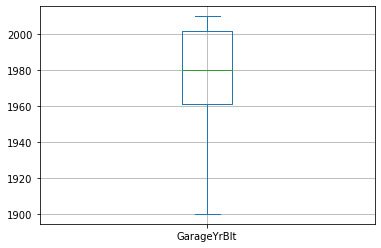

In [83]:
df['GarageYrBlt'].plot(kind='box')
plt.grid(axis='both')

In [84]:
def garageYear2Cat(x):
    if np.isnan(x):
        return 'NA'
    
    if x<1963:
        return 'old'
    if (x>=1963) and (x<=1999):
        return 'moderate'
    else:
        return 'new'


In [124]:
df['GarageYrBlt'] = df['GarageYrBlt'].apply(garageYear2Cat)
dft['GarageYrBlt'] = dft['GarageYrBlt'].apply(garageYear2Cat)


In [86]:
df['GarageYrBlt'].value_counts()

moderate    609
new         401
old         368
NA           81
Name: GarageYrBlt, dtype: int64

In [87]:
df[df.columns[np.where(df.isna().sum()>0)[0]]].select_dtypes(include='object').columns

Index([], dtype='object')

In [293]:
# Create a class to handle the preprocessing
class Preprocessor(sklearn.base.TransformerMixin):
    def __init__(self):

        self.catcols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                       'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                       'Fence', 'MiscFeature']
        self.numcols = ['LotFrontage', 'MasVnrArea']
        self.cols2removerowsfrom = ['Electrical']
        self.cols2remove = []
        
        self.num2cat = ['GarageYrBlt']
        self.num2catfn = [self._garageYear2Cat]
        
    def fit(self, X, y=None):
        return self
    
    def _garageYear2Cat(self, x):
        if np.isnan(x):
            return 'NA'

        if x<1963:
            return 'old'
        if (x>=1963) and (x<=1999):
            return 'moderate'
        else:
            return 'new'
    
    
    def transform(self, X, y=None):
        updated_X = X.copy()
        updated_X[self.catcols] = updated_X[self.catcols].fillna('NA')
        updated_X.drop(self.cols2remove, axis=1, inplace=True)
        # updated_X.drop(updated_X.index[np.where(updated_X[self.cols2removerowsfrom].isna())[0]], inplace=True)
        updated_X[self.numcols] = updated_X[self.numcols].fillna(0.0)
        for col, fn in zip(self.num2cat, self.num2catfn):
            updated_X[col] = updated_X[col].apply(fn)
        
        # Special case
        updated_X['MasVnrType'] = updated_X['MasVnrType'].fillna('NA') # Replace nans with 'NA'
        updated_X.loc[(updated_X['MasVnrType']=='None'),'MasVnrType'] = 'NA' # Update the None values with NA as well to keep the same NA valye

        
        return updated_X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [238]:
p = Preprocessor()
X = p.transform(df)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [239]:
df.equals(X)

True

In [178]:
for col in df.columns:
    if (df[col] != X[col]).sum() > 0:
        print(col)

In [181]:
df.isna().sum().sum() # If it is 0, then we are good to go

0

In [88]:
df.set_index('Id', inplace=True)

In [17]:
df.to_csv('./data/clean_data.csv')

In [89]:
np.random.seed(101)
df_test = df.sample(frac=0.2)
df_train = df.drop(df_test.index)

In [90]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000


In [270]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167 entries, 1 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1167 non-null   int64  
 1   MSSubClass     1167 non-null   int64  
 2   MSZoning       1167 non-null   object 
 3   LotFrontage    1167 non-null   float64
 4   LotArea        1167 non-null   int64  
 5   Street         1167 non-null   object 
 6   Alley          1167 non-null   object 
 7   LotShape       1167 non-null   object 
 8   LandContour    1167 non-null   object 
 9   Utilities      1167 non-null   object 
 10  LotConfig      1167 non-null   object 
 11  LandSlope      1167 non-null   object 
 12  Neighborhood   1167 non-null   object 
 13  Condition1     1167 non-null   object 
 14  Condition2     1167 non-null   object 
 15  BldgType       1167 non-null   object 
 16  HouseStyle     1167 non-null   object 
 17  OverallQual    1167 non-null   int64  
 18  OverallC

In [91]:
cat_cols = df_train.select_dtypes(include=['object']).columns
num_cols = set(df_train.columns)-set(cat_cols)

In [92]:
len(cat_cols), len(num_cols)

(44, 36)

In [93]:
df_train[cat_cols].nunique().describe()

count    44.000000
mean      6.022727
std       4.008646
min       2.000000
25%       4.000000
50%       5.000000
75%       6.250000
max      25.000000
dtype: float64

In [94]:
col_min_max = {}
for col in cat_cols:
    cnts = df_train[col].value_counts()
    col_min_max[col] = [cnts.min(), cnts.max()]

pd.DataFrame(col_min_max, index=['min','max']).iloc[0,:].describe()
# Picking threshold 20

count    44.000000
mean     13.613636
std      18.064762
min       1.000000
25%       1.000000
50%       5.000000
75%      23.750000
max      73.000000
Name: min, dtype: float64

In [95]:
# First hyper parameter (lower limit to exclude categorical values to limit the date dimensionality)
threshold=20
for col in cat_cols:
    idx = np.where(df_train[col].value_counts() < threshold)
    old_values = df_train[col].value_counts().index[idx]
    df_train[col] = df_train[col].apply(lambda x: 'other' if x in old_values.tolist() else x)

In [96]:
old_values.to_list()

['Family', 'Alloca', 'AdjLand']

In [135]:
# Calculate the new dimensionality
added_dims = 0
for cat in cat_cols:
    added_dims += df_train[cat].nunique()
print(added_dims)

199


In [345]:
class RemoveLowFreqCategories(sklearn.base.TransformerMixin):
    def __init__(self, threshold=20, cat_cols=[]):
        self.threshold = threshold 
        self.cat_cols=cat_cols
        self.old_vals_ = {}
        
    def fit(self, X, y=None):
        # First hyper parameter (lower limit to exclude categorical values to limit the date dimensionality)
        for col in cat_cols:
            idx = np.where(X[col].value_counts() < self.threshold)
            old_values = X[col].value_counts().index[idx]
            self.old_vals_[cat] = old_values
            # X[col] = X[col].apply(lambda x: 'other' if x in old_values.tolist() else x)
        return self
    
    def transform(self, X, y=None):
        # uX = X.copy()
        # for col in self.cat_cols:
        #     idx = np.where(uX[col].value_counts() < self.threshold)
        #     old_values = uX[col].value_counts().index[idx]
        #     uX[col] = uX[col].apply(lambda x: 'other' if x in old_values.tolist() else x)     
        # return uX
        return X
    
    def fit_transform(self, X, y=None):
        uX = X.copy()
        for col in cat_cols:
            idx = np.where(X[col].value_counts() < self.threshold)
            old_values = X[col].value_counts().index[idx]
            self.old_vals_[cat] = old_values
            X[col] = X[col].apply(lambda x: 'other' if x in old_values.tolist() else x)
        return uX

In [97]:
ohe_dict = {}
for cat in cat_cols:
    ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
    X_train_cat = pd.DataFrame(ohe.fit_transform(df_train[[cat]]).toarray(), index=df_train.index, columns=ohe.get_feature_names([cat]))
    X_test_cat = pd.DataFrame(ohe.transform(df_test[[cat]]).toarray(), index=df_test.index, columns=ohe.get_feature_names([cat]))

    df_train.drop(cat, axis=1, inplace=True)
    df_test.drop(cat, axis=1, inplace=True)

    df_train = pd.concat([df_train, X_train_cat], axis=1)
    df_test = pd.concat([df_test, X_test_cat], axis=1)

    ohe_dict[cat] = ohe

In [127]:
for cat, ohe in ohe_dict.items():
    Xt = pd.DataFrame(ohe.transform(dft[[cat]]).toarray(), index=dft.index, columns=ohe.get_feature_names([cat]))

    dft.drop(cat, axis=1, inplace=True)

    dft = pd.concat([dft, Xt], axis=1)


In [198]:
# Embed the OHE in a class
class CategoricalHandler(sklearn.base.TransformerMixin):
    def __init__(self, catcols=[]):
        self.catcols = catcols
        self.ohe_dict_ = {}

    def fit(self, X, y=None):
        for cat in self.catcols:
            ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
            ohe.fit(X)
            self.ohe_dict_[cat] = ohe
        return self
    
    def transform(self, X, y=None):
        uX = X.copy()
        for cat, ohe in self.ohe_dict_.items():
            X_train_cat = pd.DataFrame(ohe.fit_transform(uX[[cat]]).toarray(), index=uX.index, columns=ohe.get_feature_names([cat]))
            uX.drop(cat, axis=1, inplace=True)
            uX = pd.concat([uX, X_train_cat], axis=1)
        return uX
    
    def fit_transform(self, X, y=None):
        uX = X.copy()
        for cat in self.catcols:
            ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
            X_train_cat = pd.DataFrame(ohe.fit_transform(uX[[cat]]).toarray(), index=uX.index, columns=ohe.get_feature_names([cat]))
            uX.drop(cat, axis=1, inplace=True)
            uX = pd.concat([uX, X_train_cat], axis=1)
            self.ohe_dict_[cat] = ohe

        return uX
        

In [4]:
# df_train.to_csv('./data/train_preprocessed.csv')
df_train = pd.read_csv('./data/train_preprocessed.csv', index_col=0)

In [99]:
df_train.shape, df_test.shape

((1167, 235), (292, 235))

In [139]:
df_tr = df_train.sample(frac=0.8)
df_val = df_train.drop(df_tr.index)

In [140]:
df_tr.shape, df_val.shape

((934, 235), (233, 235))

In [141]:
list(filter(lambda x: 'price' in x.lower(), df_tr.columns))

['SalePrice']

In [101]:
# Split X, y
X_tr = df_train.drop('SalePrice', axis=1)
y_tr = df_train[['SalePrice']]

X_tes = df_test.drop('SalePrice', axis=1)
y_tes = df_test[['SalePrice']]



# X_val = df_val.drop('SalePrice', axis=1)
# y_val = df_val['SalePrice']

In [7]:
# Normalizer
sc_std = sklearn.preprocessing.StandardScaler()
sc_minmax = sklearn.preprocessing.MinMaxScaler()

In [128]:
X_tr_std = sc_std.fit_transform(X_tr)
X_test_std = sc_std.transform(X_tes)
Xtft = sc_std.transform(dft)
# X_val_std = sc_std.transform(X_val)
# y_tr_std = sklearn.preprocessing.StandardScaler().fit_transform(y_tr)

# X_tr_minmax = sc_minmax.fit_transform(X_tr)
# X_val_minmax = sc_minmax.transform(X_val)

In [55]:
# Perform the feature selection

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from skopt import BayesSearchCV
from sklearn.linear_model import Ridge

In [11]:
MAX_ITR = int(1e9)

REG_DICT = {
    'lsvm': lambda: sklearn.svm.LinearSVR(max_iter=MAX_ITR),
    'ridge': lambda: Ridge(max_iter=MAX_ITR),
    'knn': KNeighborsRegressor,
    'xgb': xgboost.XGBRegressor,
    'rf': sklearn.ensemble.RandomForestRegressor,
    'svm': lambda: sklearn.svm.SVR(max_iter=MAX_ITR),
    'nn': lambda: MLPRegressor(max_iter=MAX_ITR),
    'gradboost': sklearn.ensemble.GradientBoostingRegressor
}
PARAM_GRID={
    'lsvm': {
        'penalty':['l1','l2'],
        'loss':['epsilon_insensitive','squared_epsilon_insensitive'],
        'C':[0.01, 0.1, 0.5, 1, 5, 10]
    },

    'xgb': {
        'n_estimators': [5, 10, 50, 100, 200, 500],
        'eta': [0.05, 0.01, 0.1, 0.3, 0.7, 1],
        'max_depth': range(1, 16),
        'booster':['gbtree','gblinear','dart'],
        'min_child_weight': [0.01, 0.5, 1, 10],
        'gamma': [0, 0.1, 1, 5, 50, 100],
        'reg_alpha':[0, 0.001, 0.5, 1, 10],
        'reg_lambda':[0, 0.001, 0.5, 1,  10],
        'colsample_bytree': [0.6, 0.8, 1.0],
    },
    'ridge':{
            'alpha':np.arange(0.1, 5, 0.1),
            'normalize':[True, False],
        },
    'knn': {
        'n_neighbors':np.arange(1,70, 2),
        'weights':['uniform','distance'],
        'leaf_size':np.arange(10,150, 10),
        'p':np.arange(1,7),
        'metric':['identifier','euclidean','manhattan','chebyshev','minkowski',
                  'wminkowski','seuclidean','mahalanobis']
        },
    'gnb': {

    },
    'rf': {
        'n_estimators':[50, 100, 200, 500, 1000],
        'criterion':['gini','entropy'],
        'max_features':['auto','sqrt'],
        'min_samples_split':[2,5,10],
        'min_samples_leaf':[0,0.1,0.2,0.3,0.4,0.5],
        'bootstrap':[True,False]

    },
    'svm': {
        'C':[0.1,1,5, 10],
        'kernel':['poly','rbf','sigmoid'],
        'degree':[2,3,4,5,6],
        'gamma':['scale','auto'],
        'coef0':[0.0,0.01,0.5,5,50,100]
    },
    'nn':{
        'hidden_layer_sizes': [(150,100,50,), (100,50,25,), (100,)],
        'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001,0.001,0.01, 0.05, 0.1, 0.5],
        'learning_rate': ['constant','adaptive'],
        'beta_1':[0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.9],
        'beta_2':[0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.9],
    },
    'gradboost':{
        'loss':['deviance','exponential'],
        'learning_rate':np.arange(0.1, 5, 0.1),
        'n_estimators':np.arange(100,500,50),
        'subsample':np.arange(0.5,1, 0.1),
        'criterion':['mse','friedman_mse'],
        'min_samples_split':np.arange(2,10, 1),
        'min_samples_leaf':np.arange(1,10,1),
        'max_depth':np.arange(3,50,1),
        'warm_start':[True],
    }
}

In [12]:
grid = RFECV(
    REG_DICT['lsvm'](),
    cv=5,
    # return_train_score=True,
)

In [17]:
rfe = RFECV(REG_DICT['rf'](),cv=5)

In [18]:
rfe.fit(X_tr_std, y_tr)

RFECV(cv=5, estimator=RandomForestRegressor())

In [19]:
rfe.grid_scores_

array([0.6736888 , 0.70883043, 0.77536547, 0.80679758, 0.81690367,
       0.82152827, 0.82590591, 0.83462594, 0.84219334, 0.84955615,
       0.8482115 , 0.84789779, 0.84499985, 0.84993345, 0.84480278,
       0.84535629, 0.84737012, 0.84826439, 0.84773639, 0.85131931,
       0.85548586, 0.84991749, 0.85366412, 0.85252382, 0.85190655,
       0.85192266, 0.85374481, 0.84858531, 0.85375297, 0.85008491,
       0.85509477, 0.85532282, 0.85484375, 0.85348102, 0.85215958,
       0.84973987, 0.85496221, 0.85839514, 0.85332423, 0.86015877,
       0.85913469, 0.85739792, 0.85681522, 0.85311428, 0.85495768,
       0.85261648, 0.85917562, 0.85503086, 0.85459244, 0.85712941,
       0.85205394, 0.85462938, 0.85206917, 0.85509916, 0.85719601,
       0.85409546, 0.85794619, 0.8559324 , 0.85492521, 0.85654184,
       0.85630314, 0.85739303, 0.85659185, 0.85819612, 0.85508063,
       0.85812922, 0.85523427, 0.85474111, 0.85450204, 0.85728529,
       0.85138219, 0.85290263, 0.85430286, 0.85472206, 0.85491

In [129]:
X_tr_selected = X_tr_std[:,np.where(rfe.support_)[0]]
X_test_selected = X_test_std[:,np.where(rfe.support_)[0]]
Xtft_selected = Xtft[:,np.where(rfe.support_)[0]]

In [25]:
X_tr_selected.shape, X_tr_std.shape

((1167, 136), (1167, 234))

In [28]:
grid = RandomizedSearchCV(
    REG_DICT['xgb'](), param_distributions=PARAM_GRID['xgb'], cv=5, n_jobs=4, n_iter=50
)

In [29]:
grid.fit(X_tr_selected, y_tr)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=4,
                   para

In [105]:
grid.score(X_test_selected, y_tes)

0.8525836453631833

In [106]:
from lossfunctions import rmslog

In [107]:
ytrain_hat = grid.predict(X_tr_selected)

In [111]:
ytest_hat = grid.predict(X_test_selected)

In [110]:
rmslog(y_tr.values, ytrain_hat)

0.5514353659839916

In [ ]:
rmslog(y_tr.values, ytrain_hat)

In [112]:
rmslog(y_tes.values, ytest_hat)

0.5420151149820666

In [142]:
dft.index.values.shape

(1459,)

In [144]:
np.vstack([dft.index.values, grid.predict(Xtft_selected)]).T

array([[  1461.      , 122871.328125],
       [  1462.      , 162100.796875],
       [  1463.      , 179813.015625],
       ...,
       [  2917.      , 171688.171875],
       [  2918.      , 120676.828125],
       [  2919.      , 230684.125   ]])

In [146]:
pd.DataFrame(np.vstack([dft.index.values, grid.predict(Xtft_selected)]).T, columns=['Id', 'SalePrice']).to_csv('submit.csv')

In [116]:
dft.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [77]:
clc = REG_DICT['svm']()

In [78]:
clc.fit(X_tr_std, y_tr)

SVR(max_iter=1000000000)

In [89]:
grid.score(X_tr_std, y_tr)

0.48403234424908004

# Build a pipeline

In [147]:
from sklearn.pipeline import Pipeline

In [348]:
df = pd.read_csv(os.path.join(DATA_PATH_TRAIN),index_col=0)
dft = pd.read_csv('./data/test.csv', index_col=0)

In [349]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = set(df.columns)-set(cat_cols)

In [284]:
df.shape

(1460, 80)

In [350]:
df[df['Electrical'].isna()].index

Int64Index([1380], dtype='int64', name='Id')

In [351]:
df.drop(df[df['Electrical'].isna()].index,inplace=True)

In [290]:
df.shape

(1459, 80)

In [352]:
pipe = Pipeline(
    [
        ('cleaner', Preprocessor()),
        ('feat_eng1', RemoveLowFreqCategories(20, cat_cols)),
        ('feat_eng2', CategoricalHandler(cat_cols.tolist()+['GarageYrBlt'])),
        ('norm', sklearn.preprocessing.StandardScaler()),
        ('rfe', RFECV(REG_DICT['xgb'](), cv=5)),
        ('grid', RandomizedSearchCV(REG_DICT['xgb'](), param_distributions=PARAM_GRID['xgb'], cv=5, n_jobs=4, n_iter=50))
    ]
)

In [353]:
pipe.fit(df.drop('SalePrice', axis=1), df['SalePrice'])

Pipeline(steps=[('cleaner',
                 <__main__.Preprocessor object at 0x00000220AAF3AB50>),
                ('feat_eng1',
                 <__main__.RemoveLowFreqCategories object at 0x00000220AAF3AC40>),
                ('feat_eng2',
                 <__main__.CategoricalHandler object at 0x00000220AAF3A0D0>),
                ('norm', StandardScaler()),
                ('rfe',
                 RFECV(cv=5,
                       estimator=XGBRegressor(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsampl...
                                                           verbosity=None),
                                    n_iter=50, n_jobs=4,
                                    param_distributions={'booster': ['gbtree',
                                                                     'gblinear',
                                                                     'dart'],
      

In [336]:
pipe.transform(df.drop('SalePrice', axis=1)).shape

AttributeError: 'XGBRegressor' object has no attribute 'transform'

In [337]:
df_clean = pipe['cleaner'].transform(df.drop('SalePrice',axis=1))

In [338]:
df_clean = pipe['feat_eng1'].transform(df_clean)

In [339]:
df_clean = pipe['feat_eng2'].transform(df_clean)

In [340]:
df_clean.shape

(1459, 79)

In [327]:
dft_clean = pipe['cleaner'].transform(dft)

In [328]:
dft_clean = pipe['feat_eng1'].transform(dft_clean)

In [331]:
dft_clean = pipe['feat_eng2'].transform(dft_clean)

In [332]:
dft_clean.shape

(1459, 79)

In [354]:
preds = pipe.predict(dft)

ValueError: X has 294 features, but StandardScaler is expecting 305 features as input.